# ARIMA, SARIMA, and SARIMAX Model

ARIMA Stands for:
* A = Auto
* R = Regressive
* I = Integrated
* M = Moving
* A = Average

ARIMA, SARIMA, and SARIMAX are relatives. each have their own special way in handling data. But, ARIMA is the foundation of those 3 models.

SARIMA = ARIMA with Seasonal concept. SARIMA Recognize repeating patterns.
SARIMAX = Not only recognize repeating patterns, it recognize external factors too!

## Case Study Briefing: Daily Chocolate Revenues

We own a chocolate store.

Goal: Predict the daily revenue

The challenge will be:
- Explore past sales
- Identify patterns
- Forecast sales

# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Useful Functions

### Model Assessment

In [3]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
    # Plot training, test, and forecasts
    plt.figure(figsize=(10, 4))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Forecast')
    plt.title(f"Train, Test, and Predictions with {chart_title}")
    plt.legend()
    plt.show()

    # Calculating MAE, MSE, MAPE, RMSE
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = root_mean_squared_error(test, predictions)

    print(f'Mean Absolute Error              : {mae}')
    print(f'Mean Absolute Percentage Error   : {mape * 100:.2f}')
    print(f'Mean Squared Error               : {mse}')
    print(f'Root Mean Squared Error          : {rmse}')

### Predicting the Future

In [4]:
# Function to plot the future
def plot_future(y, forecast, title):
    # Plot training, test, and forecasts
    plt.figure(figsize=(10, 4))
    plt.plot(y, label='Train')
    plt.plot(forecast, label='Forecast')
    plt.title(f"Train, Test, and Predictions with {title}")
    plt.legend()
    plt.show()

# Import Dataset

In [5]:
data = pd.read_csv("../dataset/daily_revenue.csv", index_col="date", parse_dates=True, dayfirst=True)
data.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq=None)

In [6]:
data.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [8]:
# Transform revenue into Float
data['revenue'] = data['revenue'].str.replace(",","").astype(float)

In [9]:
# Setting the frequency
data = data.asfreq('D')

In [10]:
# Change the time series variable name
data = data.rename(columns={'revenue': 'y'})

In [11]:
data.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


# Exploratory Data Analysis (EDA)

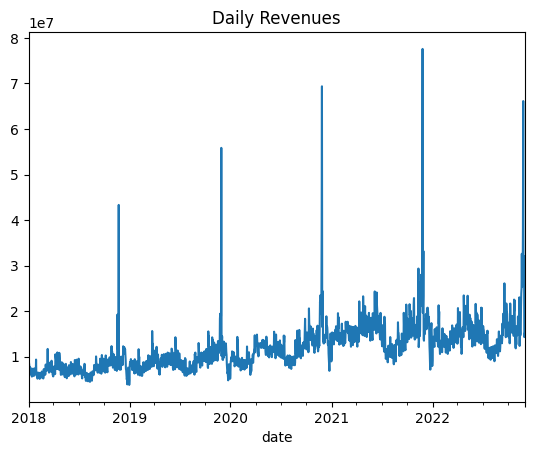

In [12]:
# Daily Closing Price Plot
data['y'].plot(title='Daily Revenues')
plt.show()

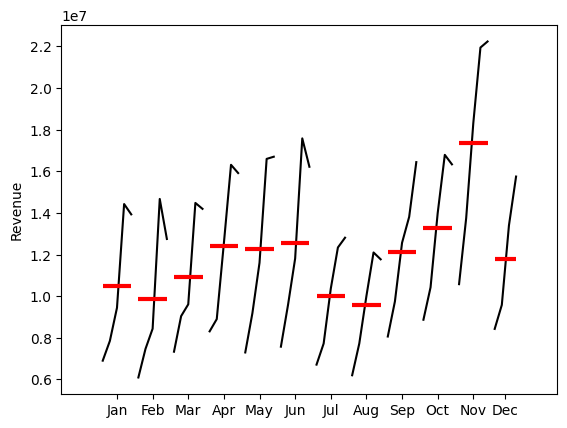

In [13]:
month_plot(data['y'].resample('ME').mean(), ylabel='Revenue')
plt.show()

/var/folders/9_/fy5p9d_52f9d3dxp8df05zlc0000gn/T/ipykernel_4622/3458681034.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(data['y'].resample('Q').mean(), ylabel='Revenue')


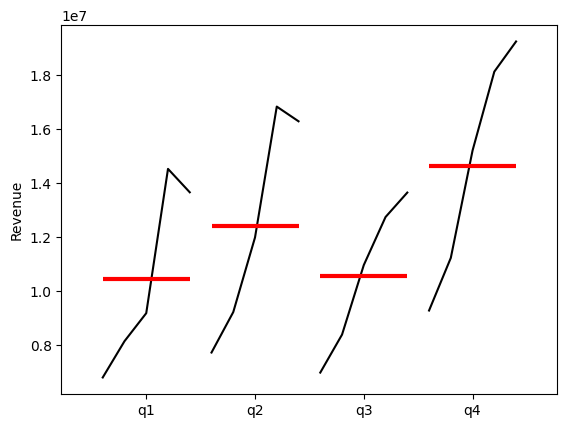

In [14]:
quarter_plot(data['y'].resample('Q').mean(), ylabel='Revenue')
plt.show()

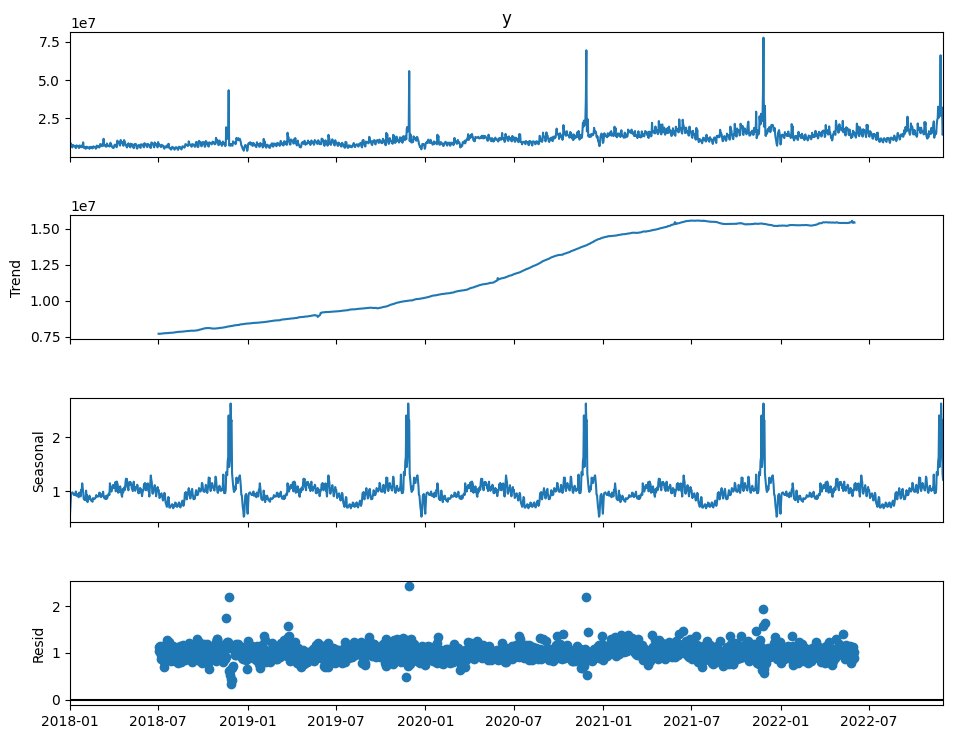

In [15]:
# Seasonal Decomposition Plots for Revenue Data
decomposition = seasonal_decompose(data['y'], model='multiplicative', period=365)

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

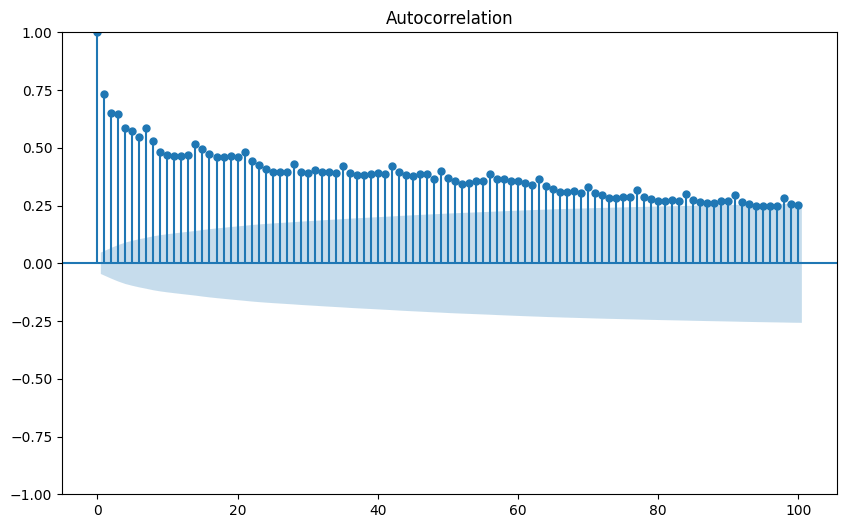

In [16]:
# Python Auto Correlation
fig, ax = plt.subplots(figsize=(10,6))
plot_acf(data['y'], lags=100, ax=ax)
plt.show()

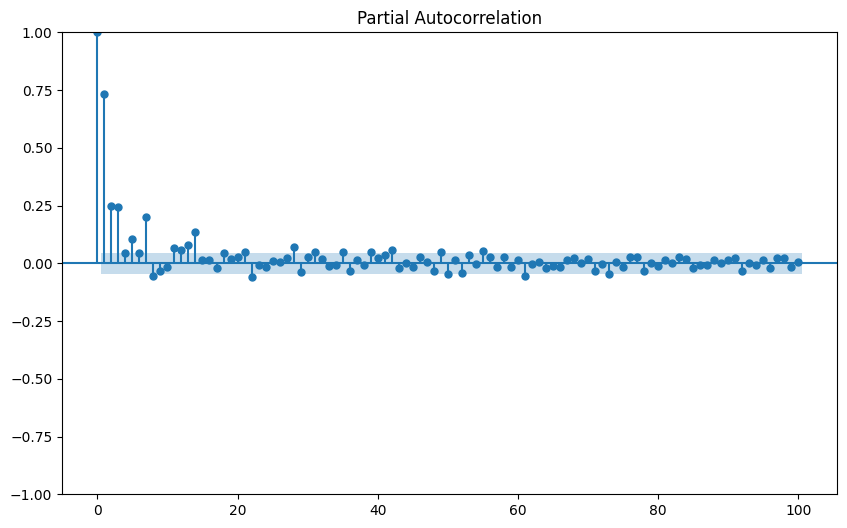

In [17]:
# Python Partial Auto Correlation
fig, ax = plt.subplots(figsize=(10,6))
plot_pacf(data['y'], lags=100, ax=ax)
plt.show()

## ARIMA

Auto Regressive Integrated Moving Average (ARIMA) model is user friendly, easy, and accurate.

It consist of 3 main parts:
1. Autoregressive (AR) = Exploring the past to predict the future.
2. Integrated (I) = Turns data into stationary, having constant mean and variance and also co-variance meaning we have a consistent pattern that can be predicted.
3. Moving Averagre (MA) = We use part errors to improve future predictions.

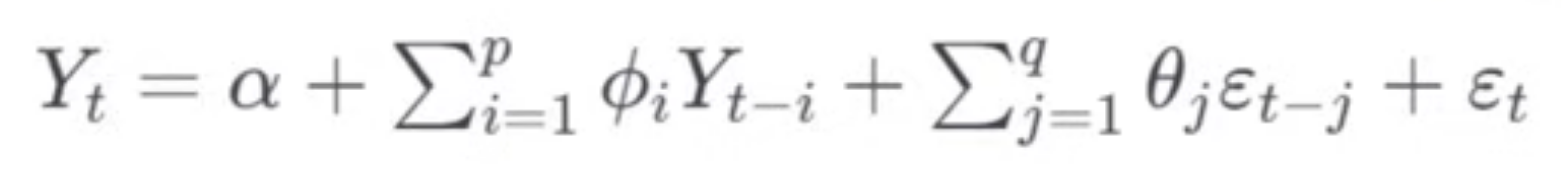

* Y_t = Value of time series at time t.
* alpha = constant
* phi_i = coefficients for auto regressive (AR)
* theta_j = coefficients for moving average (MA)
* epsilon_t = error for current time t.

**Autoregressor (AR)** uses a mechanics called 'lags' which is just previous data points in the time series. Lag is like a backward step, so lag of 1 means yesterday. A lag of 2 means the day before yesterday or 2 days ago.

AR is represetned as P is ARIMA which describes the number of lagged values. so ARIMA(2,d,q) means we are using the last two days coffee transaction to predict.

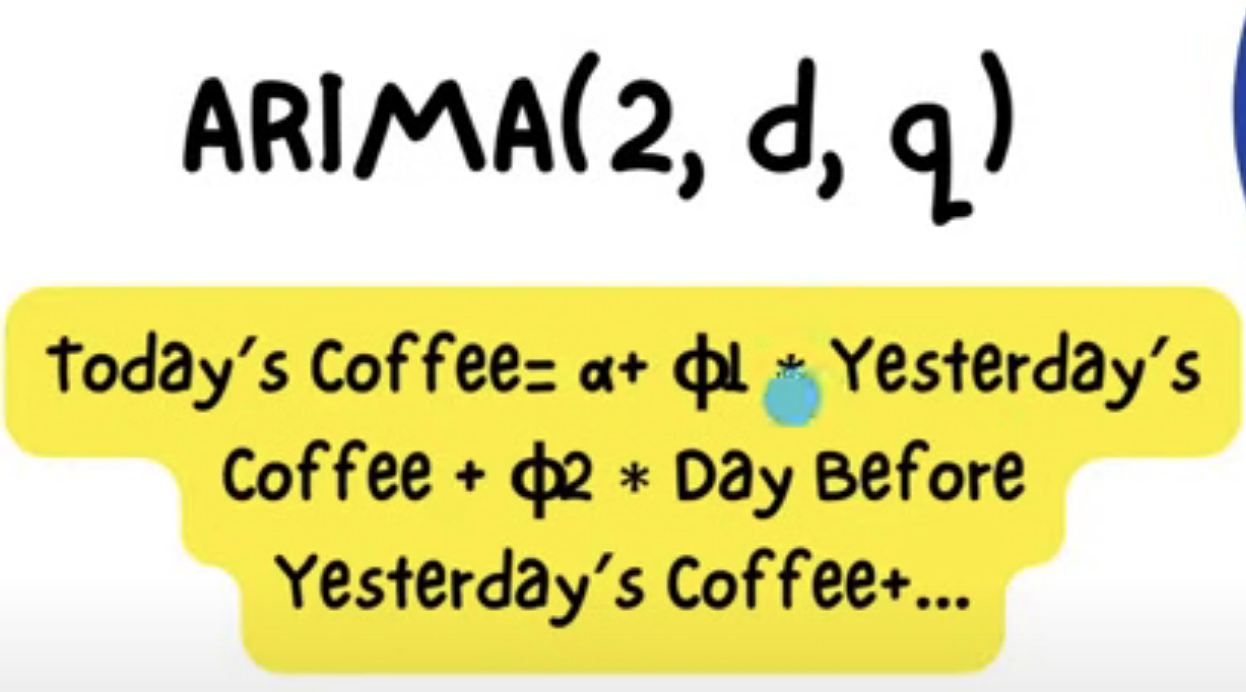

**Integrated (I)** to understand integrated, think of stationarity time series as a reliable train, it goes at a steady pace. It has stead speed (mean), shake (variance), ad rhythm (covariance) over time. The stable patterns make prediction easier. But most of the times the data is not stationary. So we have a called differencing. Differencing smooths out the ups and downs by subtracting consecutive days which yields a steadier and more predictable series.

Integrated is how many times do you have to do differencing to make the data stationary.

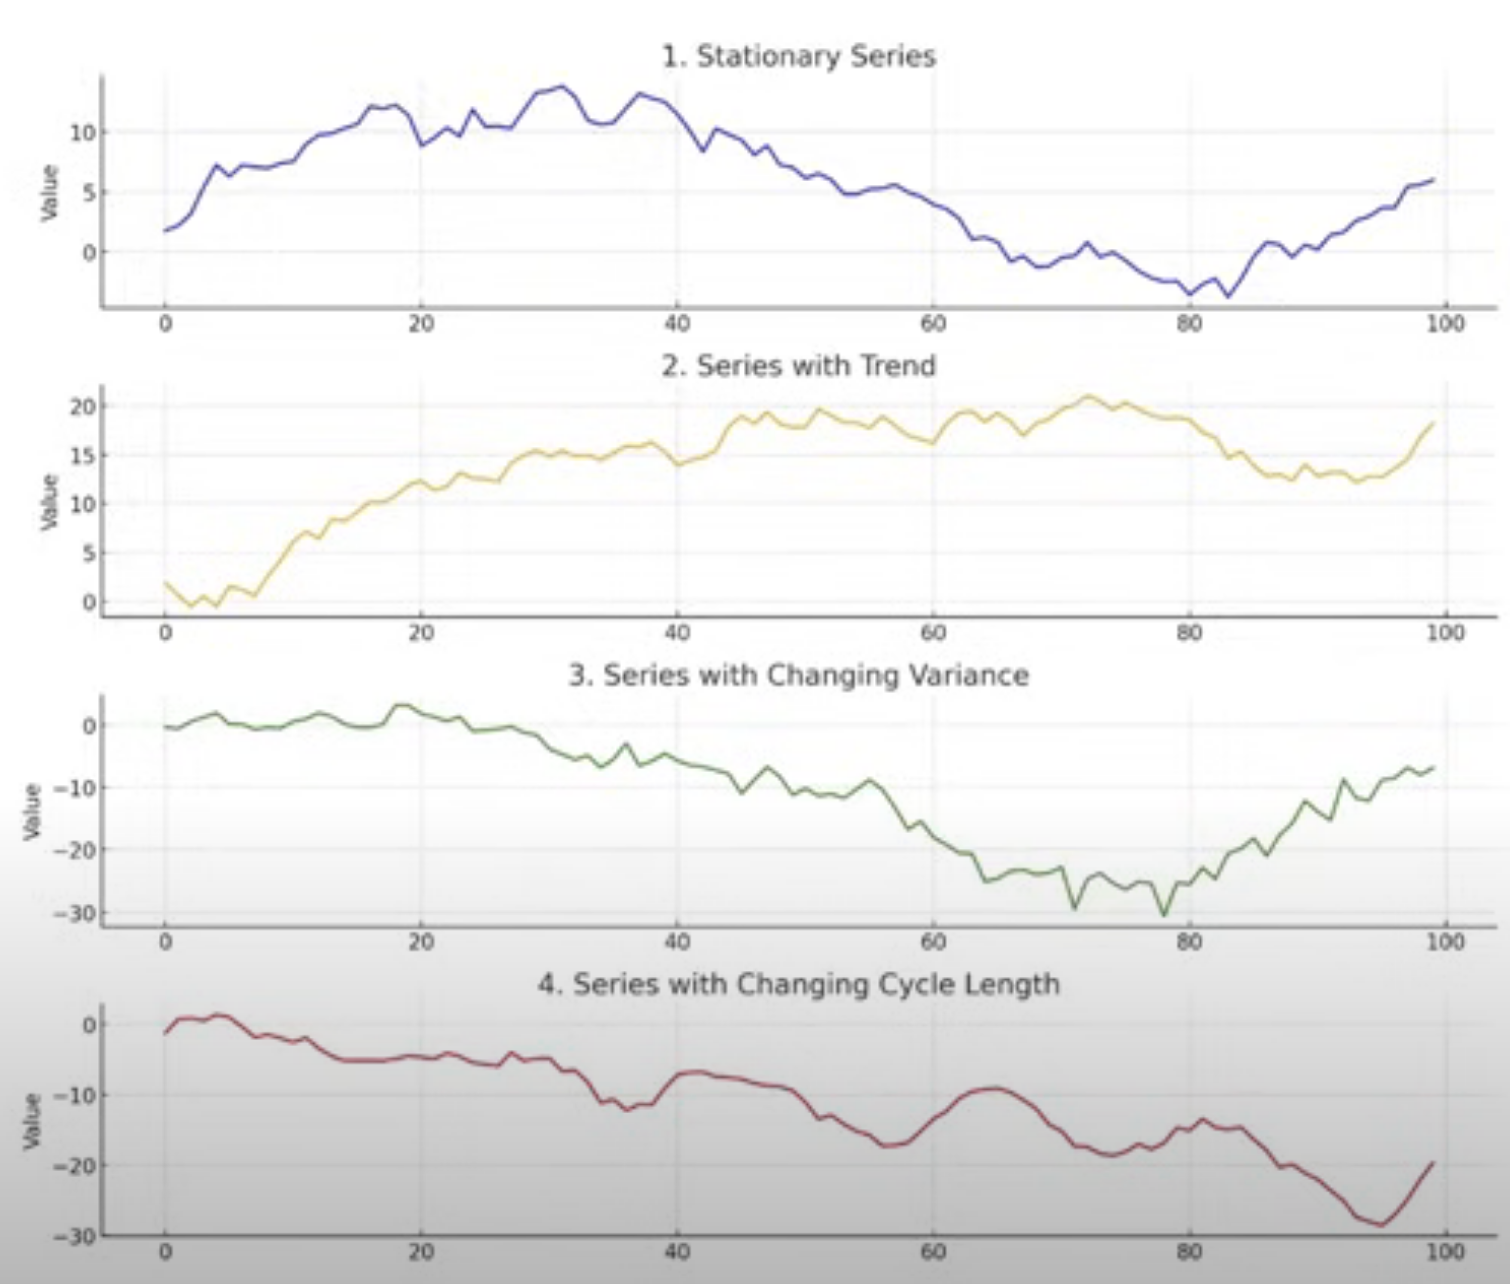

The (1) has stable patterns and is called stationary.

The (2) grows overtime, so the mean changes overtime. Therefore it is not stationary.

The (3) has varying amplitudes, so the variance changes over time. Therefore it is not stationary.

The (4) has varying cycles, so it is not stationary.

Real world data is very tricky because most real world data is not stationary. That is why we need differencing.

How do I know if my data is stationary?

We can use the Augmented Dickey-Fuller test which is a method to test whether the mean, variance, and covariance is constant over time.

## Stationarity

In [18]:
# Perform ADF Test
result = adfuller(data.y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
    print(f"   {key}: {value}")
    # print("\t%s: %.3f" % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print('Evidence suggests that the times series is stationary.')
else:
    print('Evidence suggests that the times series is NOT stationary.')

ADF Statistic: -2.558400
p-value: 0.101904
Critical values:
   1%: -3.4340436225819664
   5%: -2.8631715289228103
   10%: -2.567638575476797
Evidence suggests that the times series is NOT stationary.


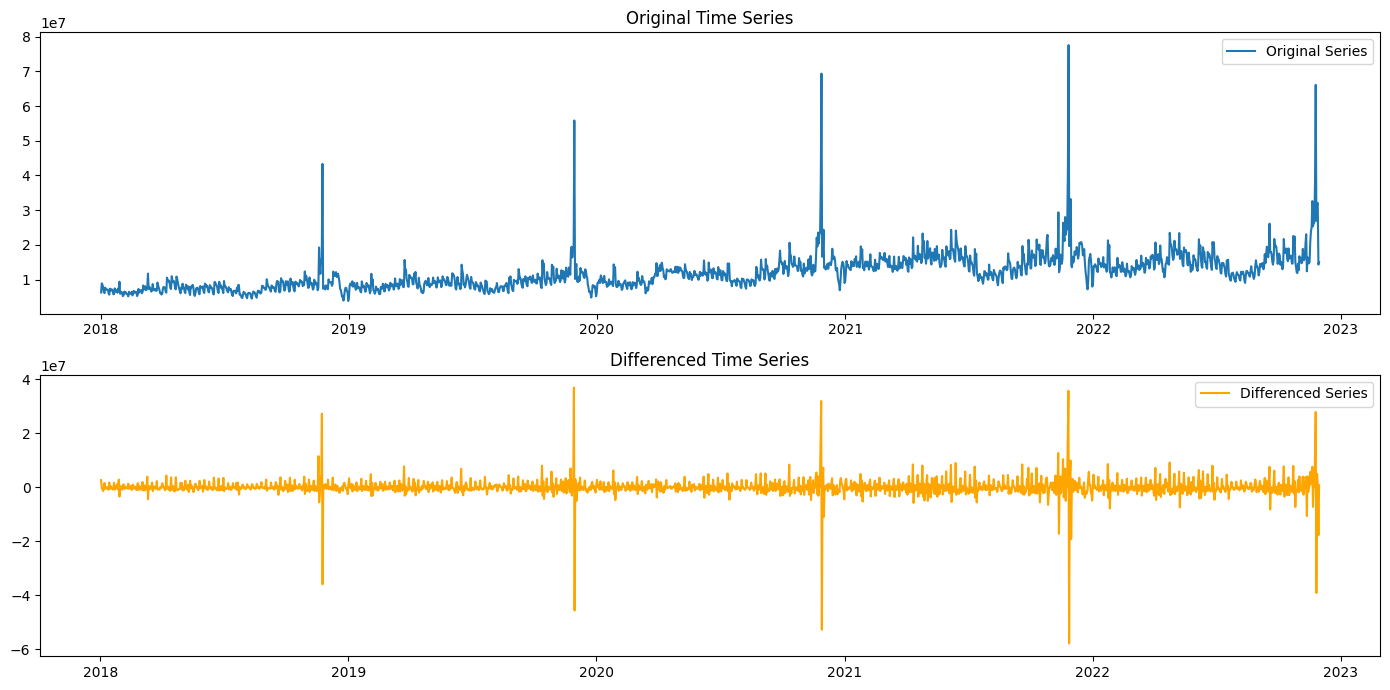

In [19]:
# Difference the series
data['y_diff'] = data.y.diff().dropna()

# Plotting the original and differenced series
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)    # 2 rows, 1 column, 1st subplot
plt.plot(data.y, label='Original Series')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)    # 2 rows, 1 column, 2nd subplot
plt.plot(data.y_diff, label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.show()

Most likely, after doing first order differencing, we'll end up with stationary data. Now let's recheck the stationarity using the differenced data.

In [20]:
# Perform ADF Test
result = adfuller(data.y_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
    print(f"   {key}: {value}")
    # print("\t%s: %.3f" % (key, value))

# Interpreting the results
if result[1] < 0.05:
    print('Evidence suggests that the times series is stationary.')
else:
    print('Evidence suggests that the times series is NOT stationary.')

ADF Statistic: -12.808787
p-value: 0.000000
Critical values:
   1%: -3.4340436225819664
   5%: -2.8631715289228103
   10%: -2.567638575476797
Evidence suggests that the times series is stationary.


### **ADF Statistics From scratch**

This formula although is done from scratch, but it is oversimplified as it does not cover higher order differenciation, and the p value is not automatically picked. so adfuller is way more accurate and reliable. another method than ADF is KPSS method to proof hyphotesis.

In [21]:
# # 📊 Manual ADF Test Calculation using OLS
# # Example time series: y = [2, 3, 5]

# import numpy as np

# # Step 1: Original time series
# y = np.array([2, 3, 5])  # t = 1, 2, 3

# # Step 2: First difference Δy_t = y_t - y_{t-1}
# delta_y = y[1:] - y[:-1]  # [3-2, 5-3] = [1, 2]

# # Step 3: Lagged level y_{t-1}
# y_lag = y[:-1]  # [2, 3]

# # Now we are regressing Δy_t on y_{t-1} (no constant, no lag of Δy)
# # Model: Δy_t = γ * y_{t-1} + ε_t

# # Reshape for matrix operation
# X = y_lag.reshape(-1, 1)     # shape (2,1)
# Y = delta_y.reshape(-1, 1)   # shape (2,1)

# # Step 4: Apply OLS manually
# # β̂ = (XᵀX)⁻¹ XᵀY
# XtX_inv = np.linalg.inv(X.T @ X)
# XtY = X.T @ Y
# gamma_hat = XtX_inv @ XtY

# # Step 5: Predicted Δy_t and residuals
# Y_hat = X @ gamma_hat
# residuals = Y - Y_hat

# # Step 6: Estimate variance of residuals
# n = len(Y)
# k = X.shape[1]  # number of predictors = 1
# sigma_squared = np.sum(residuals**2) / (n - k)

# # Step 7: Calculate standard error of γ
# se_gamma = np.sqrt(sigma_squared * XtX_inv[0][0])

# # Step 8: Calculate ADF statistic
# adf_stat = gamma_hat[0][0] / se_gamma

# # Step 9: Output results
# print("γ (coefficient for y_{t-1}):", gamma_hat[0][0])
# print("Standard Error:", se_gamma)
# print("ADF Statistic:", adf_stat)

# # Step 10: Manually compare with critical values
# print("\nTypical critical values:")
# print("1% level: -3.5")
# print("5% level: -2.9")
# print("10% level: -2.6")


Moving Average (MA) illustration: Imagine that you have to predict how much coffee you need tomorrow. You can look at how much coffee you drank yesterday and 2 days ago. That is the auto regressive part. But what if you consider the mistakes you've made. Let's say you expect to drink a lot of coffee yesterday, but you ended up drinking not that much amount of coffee. The MA part is the part that learn from these small mistakes. It helps us fine tune the prediction based on recent mistakes.

Why do we need MA?
* For smoothing things out preventing drastic decisions.
* Helpful for quick adjustment, it can adapt to recent drops

It basically adds a smart touch to forecasting.

# ARIMA Model

# Train Test Split

In [22]:
# Train and test split
# using the last 30 days as test data
periods = 30
train, test = data.iloc[:-periods,:], data.iloc[-periods:, :]
train.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0


In [23]:
# Pretty much equivalent of auto_arima my pmdarima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

# STEP 1: Estimate best p, q (we'll manually determine d using ADF test)
y = train['y']

# STEP 2: Estimate d using Augmented Dickey-Fuller Test
adf_result = adfuller(y)
d = 0 if adf_result[1] < 0.05 else 1  # basic rule: if p-value < 0.05, data is stationary

# STEP 3: Find best p and q using BIC or AIC
order_selection = arma_order_select_ic(y.diff().dropna() if d == 1 else y,
                                       ic='aic', max_ar=5, max_ma=5)
p, q = order_selection.aic_min_order

# STEP 4: Fit ARIMA model
model = ARIMA(y, order=(p, d, q)).fit()

# STEP 5: Summary
print(model.summary())

/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1765
Model:                 ARIMA(4, 0, 4)   Log Likelihood              -28816.367
Date:                Fri, 08 Aug 2025   AIC                          57652.733
Time:                        11:38:36   BIC                          57707.492
Sample:                    01-01-2018   HQIC                         57672.967
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.171e+07   1.67e-09   7.01e+15      0.000    1.17e+07    1.17e+07
ar.L1          1.5357      0.050     30.821      0.000       1.438       1.633
ar.L2         -0.6880      0.107     -6.456      0.0

/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# # pmdarima's auto_arima
# model = auto_arima(train['y'], seasonal=False)
# model.summary()

In [ ]:
model = ARIMA(train['y'], order=(5, 1, 2)).fit()
print(model.summary())

/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1765
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -28817.267
Date:                Fri, 08 Aug 2025   AIC                          57650.535
Time:                        11:38:37   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.0

In [26]:
# Predict next len(test) steps into the future
n_periods = len(test)
predictions_arima = model.forecast(steps=n_periods)

# Optional: Align index with test set
predictions_arima.index = test.index  # if test has a datetime index

In [27]:
predictions_arima

date
2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, Name: predicted_mean, dtype: float64

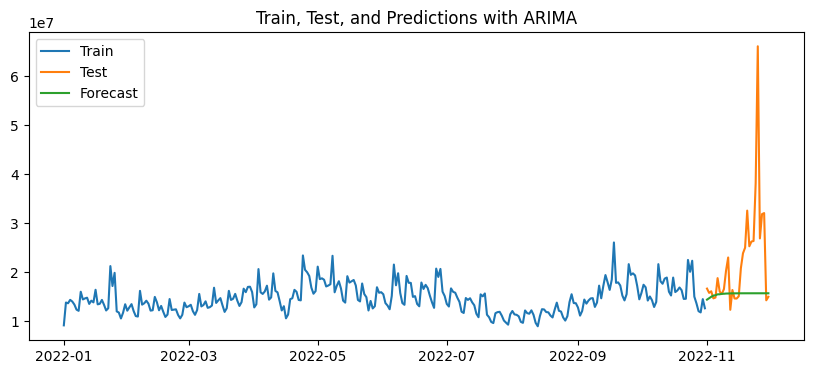

Mean Absolute Error              : 7267306.034610459
Mean Absolute Percentage Error   : 24.15
Mean Squared Error               : 152918903508823.97
Root Mean Squared Error          : 12366038.31098804


In [28]:
model_assessment(train['y']['2022':], test['y'], predictions_arima, 'ARIMA')

The ARIMA model failed to predict the spike.

## AIC & BIC

AIC : Akaike Information Criterion <br/>
BIC : Bayesian Information Criterion

AIC and BIC are KPIs to help use choose our model. They are both responsible of giving a score to the model just like a judge. They check it based on 2 criteria, which are:
- Model Fit quality
- Number of parameters used

AIC seeks balance, so it expects a model to be well-fitting without excessive parameters. The analogy is like making a GREAT cake with the LEAST ingredients used.

BIC is very similar, but it gives larger penalty for models with more parameters. So it wants everything to be simpler.

In Auto ARIMA, it calculates AIC and BIC using different combinations of parameters and pick the model with best value (lowest AIC & BIC).

Pros:
- It's straightforward in delivering the best model that is objective and data-driven as it's based on KPIs.
- Prevents overfitting, as it propose penalty for complexity. So it needs a model that generalizes well.
- Flexibility, AIC and BIC is the type of KPI that can be used in many different models and not just ARIMA, SARIMA, and SARiMAX (e.g. segmentation, regression).

Cons:
- Relative Measures. They don't really give you a good or bad scores. so the AIC and BIC is only meaningful when compared with other models' scores.
- It doesn't have a business focus. The scoring metrics (fitness and num of param) is not based on business needs.
- Information loss. As it penalizes complexity, there is a chance of this missing models that captures nuances in the data.

## SARIMA

SARIMA is an ARIMA type model that handles seasonality. It provides more insights on the cyclical patterns. <br />
SARIMA = SEASONAL Auto Regressive Integrated Moving Average.

`SARIMA(p,d,q)(P,D,Q)m`

* p,d,q = non-seasonal components.
* P,D,Q = seasonal components

P is for the seasonal autoregressive order. <br >
D is for the seasonal differencing order. <br >
Q is for the seasonal moving average order. <br >
m is for the number of period in each season. (similar to exp smoothing, 52 for weekly, and 12 for monthly)

How SARIMA works?
* Seasonal Auto Regressive (P): Looking at past seasonal data to forecast future data.
* Seasonal Differencing (D): stabilizes the seasonal patterns in the data to make the data stationary.
* Seasonal Moving Average (Q): Looks into the past errors.

SARIMA is balancing seasonal and non-seasonal parameters which can be handled by pmdarima's auto_arima. It's best used on data with predictable fluctutations.

In [29]:
# # pmdarima's auto_arima
# model = auto_arima(train['y'], m=7)
# model.summary()

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [75]:
# model_sarima = SARIMAX(y, order=(5, 1, 2)).fit()
# print(model_sarima.summary())

model_sarima = SARIMAX(
    train['y'],
    order=(3, 1, 2),                  # (p, d, q)
    seasonal_order=(2, 0, 2, 7),       # (P, D, Q, m)
    # enforce_stationarity=False,
    # enforce_invertibility=False,
)

model_sarima = model_sarima.fit()
print(model_sarima.summary())


/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/reiner/Documents/GitHub/learn_time_series/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28729.262
Date:                           Fri, 08 Aug 2025   AIC                          57478.524
Time:                                   22:48:26   BIC                          57533.277
Sample:                               01-01-2018   HQIC                         57498.756
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1327      0.116      1.143      0.253      -0.095       0.360
ar.L2          0.1219      0.039      3.136

In [76]:
predictions_sarima = model_sarima.predict(start=len(train), end=len(train) + len(test) - 1)


In [77]:
predictions_sarima.tail()

2022-11-26    1.412663e+07
2022-11-27    1.773952e+07
2022-11-28    1.649771e+07
2022-11-29    1.648299e+07
2022-11-30    1.600013e+07
Freq: D, Name: predicted_mean, dtype: float64

In [78]:
# Predict next len(test) steps into the future
n_periods = len(test)
predictions_sarima = model_sarima.forecast(steps=n_periods)

# Optional: Align index with test set
predictions_sarima.index = test.index  # if test has a datetime index

In [79]:
predictions_sarima.tail()

date
2022-11-26    1.412663e+07
2022-11-27    1.773952e+07
2022-11-28    1.649771e+07
2022-11-29    1.648299e+07
2022-11-30    1.600013e+07
Freq: D, Name: predicted_mean, dtype: float64

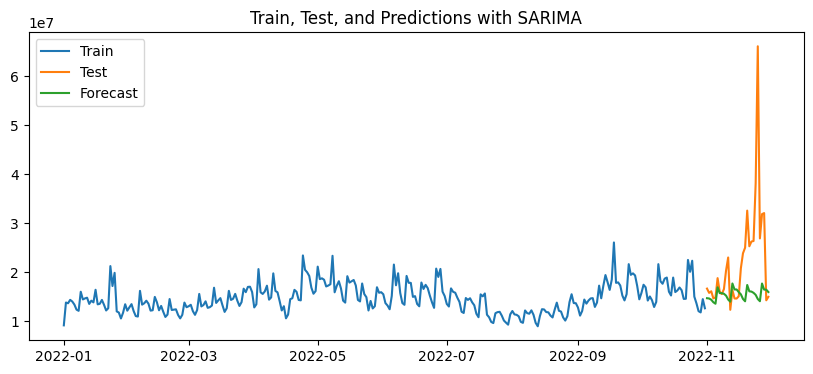

Mean Absolute Error              : 7404574.983864754
Mean Absolute Percentage Error   : 24.87
Mean Squared Error               : 156017039235127.06
Root Mean Squared Error          : 12490678.093487442


In [80]:
model_assessment(train['y']['2022':], test['y'], predictions_sarima, 'SARIMA')